In [6]:
%matplotlib inline

from pyspark import SparkContext, SparkConf

In [2]:
conf = SparkConf().setAppName("recommender")
sc = SparkContext(conf=conf)

## The MovieLens dataset

The MovieLens dataset (already available with this notebook, originally [here](https://grouplens.org/datasets/movielens/)) is a popular dataset used in recommendation engines research.
In this workshop we will use the "small" variant, consisting of 20000263 ratings for 27278 movies by 138493 users.
This dataset consist of several CSV files, namely
 * A ratings data file (`ratings.csv`)
 * A tags data file (`tags.csv`)
 * A movies data file (`movies.csv`)
 * A links data file (`links.csv`)
 * A tag genome (`genome-scores.csv` and `genome-tags.csv`)
 
 For the scope of this workshop, we are mainly interest in the rating and movies data files, which have, respectively, the following structure:
 The ratings data:
 * `userId`, a unique numerical user id
 * `movieId`, a unique numerical movie id
 * `rating`, a numerical rating, as an integer from $0$ to $5$
 * `timestamp`, a numerical timestamp (not used in this exercise)
 The movies data:
 * `movieId`, as above
 * `title`, the movie title
 * `genres` a string label with the movie genre (as listed [here](http://files.grouplens.org/datasets/movielens/ml-20m-README.html)).
 
 ### Loading the data
 
 We start by using Apache Spark's built in functionality to load text files into the Spark cluster, `.textFile()` (documented [here](http://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.SparkContext.textFile)), which will return an `RDD` of strings.
 Since `.textFile()` will read each row in the CSV file as an RDD entry, we further process it by then splitting each row into a list of CSV entries and keep only the relevant fields (i.e. `userId`, `movieId` and `rating` for the ratings, and `movieId` and `title` for the movies file).

In [3]:
def load_data(path, header, token_fun):
    """Loads the CSV file, strips the header and keeps only the specified fields"""
    return sc.textFile(path).filter(lambda x: x!=header).map(lambda x: x.split(",")).map(token_fun).cache()

movies = load_data('ml-latest-small/movies.csv', 
                   'movieId,title,genres', 
                   lambda tokens: (int(tokens[0]),tokens[1]))

ratings = load_data('ml-latest-small/ratings.csv', 
                    'userId,movieId,rating,timestamp', 
                    lambda tokens: (int(tokens[0]), int(tokens[1]), float(tokens[2])))

In [4]:
print("Number of movies: {}".format(movies.count()))
print("Number of ratings: {}".format(ratings.count()))
movies.take(5)

Number of movies: 9742
Number of ratings: 100836


[(1, 'Toy Story (1995)'),
 (2, 'Jumanji (1995)'),
 (3, 'Grumpier Old Men (1995)'),
 (4, 'Waiting to Exhale (1995)'),
 (5, 'Father of the Bride Part II (1995)')]

We can now start by exploring the data.
Let's look at the ratings distribution:

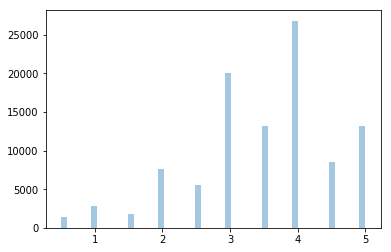

In [8]:
import seaborn as sns

r = ratings.map(lambda rating: rating[2]).collect()
sns.distplot(r, kde=False)

In [ ]:
def split_sets(ratings, proportions):
    split = ratings.randomSplit(proportions)
    return {'training': split[0], 'validation': split[1], 'test': split[2]}
    
sets = split_sets(ratings, [0.63212056, 0.1839397, 0.1839397])

In [ ]:
from pyspark.mllib.recommendation import ALS
rank = 10
iterations = 10
seed = 42
model = ALS.train(sets['training'], rank, seed=seed, iterations=iterations)

In [ ]:
validation = sets['validation'].map(lambda x: (x[0], x[1]))
validation.take(5)

In [ ]:
predictions = model.predictAll(validation)
predictions.take(10)